In [4]:
import tensorflow as tf
from tensorflow import keras
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import os
from keras.models import model_from_json
import json

Using TensorFlow backend.


In [3]:
import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)

from CO2_functions import *
from CO2_Processing import *

In [ ]:
#Get the data from CHPC
data_orig = retrieve_data_from_folder('../CO2_Data_Final','2019-11-06','2019-11-06')

In [ ]:
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
#data = sept24_26_correction(data) #add vent vel when not monitored (instrument off)
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 

In [2]:
#Processing for position 4
data_orig = retrieve_data_from_folder('../CO2_Data_Final','2019-09-24','2019-10-03')
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
data = sept24_26_correction(data) #add vent vel when not monitored (instrument off)
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 
data['Vent_Mass'] = pd.concat([\
data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-24 08:57:00')&(data['Vent_Mass'].index<'2019-09-26 08:00:00')],\
data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-26 12:00:00')&(data['Vent_Mass'].index<'2019-10-03 13:00:00')].interpolate()])

Retrieving data for 2019-09-24
Retrieving data for 2019-09-25
Retrieving data for 2019-09-26
Retrieving data for 2019-09-27
Retrieving data for 2019-09-28
Retrieving data for 2019-09-29
Retrieving data for 2019-09-30
Retrieving data for 2019-10-01
Retrieving data for 2019-10-02
Retrieving data for 2019-10-03
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero


In [2]:
#Processing for position 6
data_orig = retrieve_data_from_folder('../CO2_Data_Final','2019-11-06','2019-11-27')
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 
for key in data:
    data[key] = pd.concat([\
                               data[key].loc[(data[key].index>'2019-11-06 00:00:00')&(data[key].index<'2019-11-25 12:00:00')],\
                               data[key].loc[(data[key].index>'2019-11-25 17:00:00')&(data[key].index<'2019-11-27 10:28:00')]])


Retrieving data for 2019-11-06
Retrieving data for 2019-11-07
Retrieving data for 2019-11-08
Retrieving data for 2019-11-09
Retrieving data for 2019-11-10
Retrieving data for 2019-11-11
Retrieving data for 2019-11-12
Retrieving data for 2019-11-13
Retrieving data for 2019-11-14
Retrieving data for 2019-11-15
Retrieving data for 2019-11-16
Retrieving data for 2019-11-17
Retrieving data for 2019-11-18
Retrieving data for 2019-11-19
Retrieving data for 2019-11-20
Retrieving data for 2019-11-21
Retrieving data for 2019-11-22
Retrieving data for 2019-11-23
Retrieving data for 2019-11-24
Retrieving data for 2019-11-25
Retrieving data for 2019-11-26
Retrieving data for 2019-11-27
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero


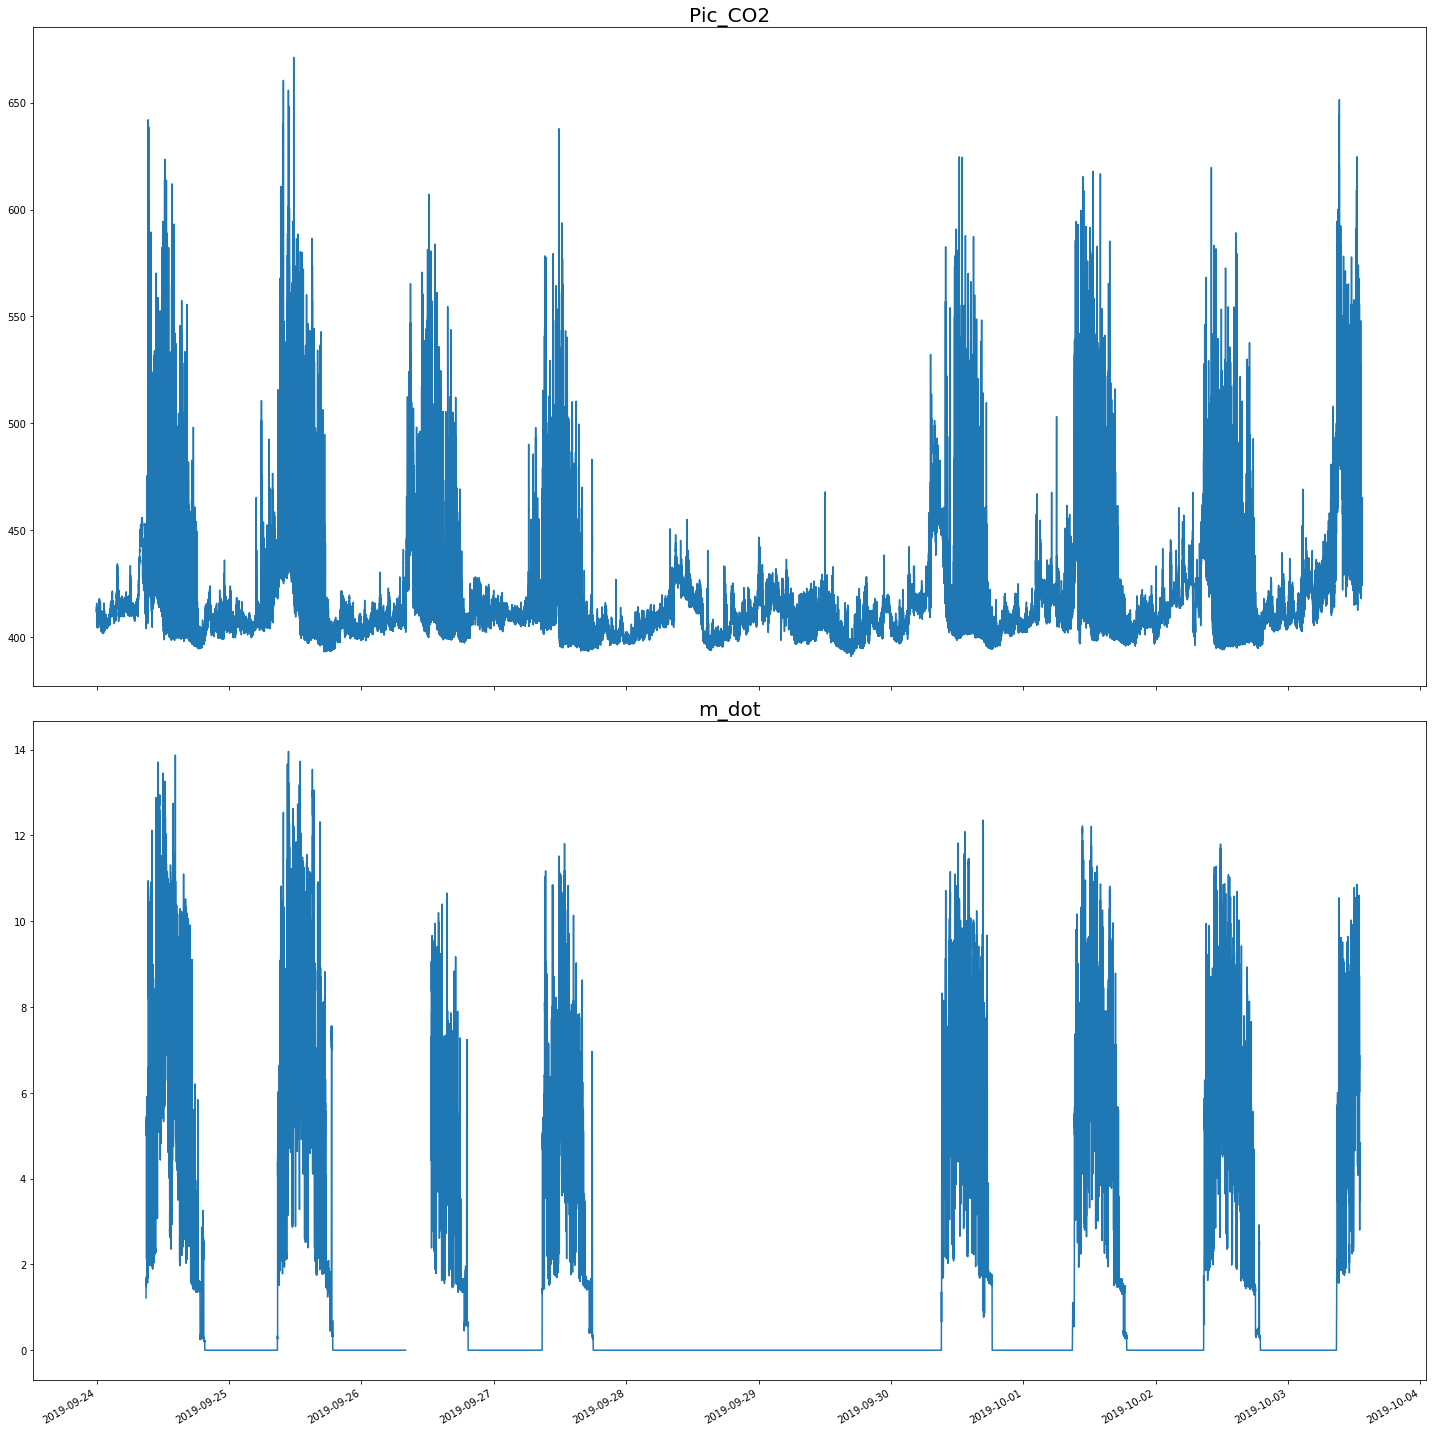

Is this an acceptable range? y


In [3]:
#Clip the picarro and vent_mass data frames to a specific region of interest

#tower_id = 'Multi'
tower_id = 'Picarro'


if tower_id == 'Multi':
    tower,vent = plot_refinement_all([[data[tower_id],'Corrected_DT','CO2_3'],\
                                    [data['Vent_Mass'],'Corrected_DT','m_dot']],\
                                   'separate')
elif tower_id == 'Picarro':
    tower,vent = plot_refinement_all([[data[tower_id],'Corrected_DT','Pic_CO2'],\
                                [data['Vent_Mass'],'Corrected_DT','m_dot']],\
                               'separate')
else:
    print('pick a valid tower')

In [4]:
#Apply a moving average and downsample
#Numbers of seconds
tower_proc = dwn_sample(tower,100)
vent_proc = dwn_sample(vent,100)

Downsampling by mean at 100 seconds
Downsampling by mean at 100 seconds


In [25]:
#Concatenate and add wind speed & direction
df = pd.concat([tower_proc,vent_proc],axis=1)
if tower_id == 'Picarro':
    df = wind_add(df,'ANEM_X','ANEM_Y')

Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'


In [26]:
#Take only necessary columns
if tower_id == 'Picarro':
    cols = ['Pic_CO2', 'ANEM_Y', 'ANEM_X', 'ANEM_Z', 'm_dot', 'wd', 'ws']
elif tower_id == 'Multi':
    cols = ['CO2_1', 'CO2_2', 'CO2_3', 'Wind_Velocity', 'Wind_Direction', 'm_dot']
    
df = df[cols]

#Make mass flux the last column
loc = df.columns.get_loc('m_dot')
cols = df.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
df = df[cols]

In [27]:
#TIME LAG
df_to_use = df

n_seconds = 3 #how many periods to lag
n_features= len(df_to_use.columns)-1 #how many features exist in the feature matrix (number of cols - target col)
time_lagged = series_to_supervised(df_to_use,n_in=0,n_out=n_seconds,dropnan=False) #lag function
time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns


#Make mass flux at t the last column
loc = time_lagged_reframed.columns.get_loc('m_dot(t)')

cols = time_lagged_reframed.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
time_lagged_reframed = time_lagged_reframed[cols]

time_lagged_reframed

,Pic_CO2(t),ANEM_Y(t),ANEM_X(t),ANEM_Z(t),wd(t),ws(t),Pic_CO2(t+1),ANEM_Y(t+1),ANEM_X(t+1),ANEM_Z(t+1),wd(t+1),ws(t+1),Pic_CO2(t+2),ANEM_Y(t+2),ANEM_X(t+2),ANEM_Z(t+2),wd(t+2),ws(t+2),m_dot(t)
Corrected_DT,,,,,,,,,,,,,,,,,,,
2019-09-23 23:56:40,412.793091,0.142484,-0.789375,-0.136851,100.231839,1.116344,412.700030,0.348316,-0.890475,-0.078872,111.363341,1.259322,411.435105,0.538827,-0.778852,-0.049651,124.676329,1.101463,NaN
2019-09-23 23:58:20,412.700030,0.348316,-0.890475,-0.078872,111.363341,1.259322,411.435105,0.538827,-0.778852,-0.049651,124.676329,1.101463,412.611022,0.657877,-0.750211,-0.102658,131.248273,1.060958,NaN
2019-09-24 00:00:00,411.435105,0.538827,-0.778852,-0.049651,124.676329,1.101463,412.611022,0.657877,-0.750211,-0.102658,131.248273,1.060958,409.303550,1.063700,-1.051366,-0.134448,135.334109,1.486856,NaN
2019-09-24 00:01:40,412.611022,0.657877,-0.750211,-0.102658,131.248273,1.060958,409.303550,1.063700,-1.051366,-0.134448,135.334109,1.486856,405.835794,0.745243,-0.986628,-0.179469,127.065336,1.395303,NaN
2019-09-24 00:03:20,409.303550,1.063700,-1.051366,-0.134448,135.334109,1.486856,405.835794,0.745243,-0.986628,-0.179469,127.065336,1.395303,407.565125,0.636872,-0.880045,-0.106882,125.892576,1.244571,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-03 13:20:00,NaN,NaN,NaN,NaN,NaN,NaN,428.947234,0.338540,0.341103,-0.258126,225.216093,0.482393,437.987568,-0.573586,0.910787,0.260077,302.201464,1.288048,NaN
2019-10-03 13:21:40,428.947234,0.338540,0.341103,-0.258126,225.216093,0.482393,437.987568,-0.573586,0.910787,0.260077,302.201464,1.288048,436.449269,-0.464448,0.985192,0.363485,295.240563,1.393272,NaN
2019-10-03 13:23:20,437.987568,-0.573586,0.910787,0.260077,302.201464,1.288048,436.449269,-0.464448,0.985192,0.363485,295.240563,1.393272,447.630755,-0.176974,1.066006,0.297525,279.426051,1.507560,NaN


In [ ]:
plot_refinement_all([[time_lagged,'Corrected_DT','Pic_CO2(t+1)'],[df,'Corrected_DT','Pic_CO2'],[time_lagged_reframed,'Corrected_DT','Pic_CO2(t+6)']],'stack')

In [ ]:
plot_refinement_all([[df,'Corrected_DT','Pic_CO2'],[df,'Corrected_DT','ws'],[df,'Corrected_DT','wd'],[df,'Corrected_DT','m_dot']],'separate')

In [28]:
values = time_lagged_reframed.dropna().values #Convert to numpy for processing
min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1

#Set train size. Because time is a factor, we do not choose randomly, but chronologically
percent_train = 0.6
train_size = int(len(values)*percent_train) 

train = values_scaled[:train_size,:]  #Get train/test arrays
test = values_scaled[train_size:,:]

X_train,y_train = train[:,:-1], train[:,-1] #Get feature/target arrays
X_test, y_test = test[:,:-1], test[:,-1]

#Store shapes prior to 3D reshape such that they can be "unreshaped" and unscaled for representative fit/test plotting
orig_X_train_shape = X_train.shape
orig_X_test_shape = X_test.shape
orig_y_train_shape = y_train.shape
orig_y_test_shape = y_test.shape

X_train = X_train.reshape((X_train.shape[0], n_seconds, n_features)) 
X_test = X_test.reshape((X_test.shape[0], n_seconds, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4616, 3, 6) (4616,) (3078, 3, 6) (3078,)


In [ ]:
#Gridsearch

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    def r_square(y_true, y_pred):
        from keras import backend as K
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return (1 - SS_res/(SS_tot + K.epsilon()))
    model = Sequential()
    model.add(LSTM(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

    model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model,verbose=10)

batch_size = [5,10,20,50,100]
epochs = [1,5]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3,verbose=10)
grid_result = grid.fit(X_train, y_train,verbose=False)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [17]:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

#Train Model
model = Sequential()
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=["mean_squared_error", rmse, r_square])
history = model.fit(X_train,y_train,epochs=5,batch_size=20,validation_data=(X_test,y_test))

Train on 4616 samples, validate on 3078 samples
Epoch 1/5
4616/4616 [==============================] - 5s 1ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - rmse: 0.1982 - r_square: -0.9291 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_rmse: 0.1450 - val_r_square: -587926.3750
Epoch 2/5
4616/4616 [==============================] - 4s 780us/step - loss: 0.0328 - mean_squared_error: 0.0328 - rmse: 0.1223 - r_square: -37494.5078 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_rmse: 0.1156 - val_r_square: -1102761.6250
Epoch 3/5
4616/4616 [==============================] - 4s 838us/step - loss: 0.0284 - mean_squared_error: 0.0284 - rmse: 0.1069 - r_square: 0.2834 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_rmse: 0.1115 - val_r_square: -1094486.1250
Epoch 4/5
4616/4616 [==============================] - 4s 825us/step - loss: 0.0286 - mean_squared_error: 0.0286 - rmse: 0.1047 - r_square: 0.2859 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_

In [ ]:
#Write out model
name = 'test'

hist_df = pd.DataFrame(history.history)
model_json = model.to_json()
with open("ML_Models/{}_model.json".format(name), "w") as json_file:
    json_file.write(model_json)
model.save_weights("ML_Models/{}_model.h5".format(name))
with open('ML_Models/{}_hist.json'.format(name), 'w') as f:
    hist_df.to_json(f)
print("Saved model to disk")

# DEVELOPMENT 
________________________
# VIEWING

In [32]:
#Read in model
path = 'ML_Models/BS20E10'

json_file = open('{}.json'.format(path), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("{}.h5".format(path))
#history = pd.read_json("{}_hist.json".format(path))
print("Loaded model from disk")

Loaded model from disk


In [14]:
#Get train/test
feature_columns = ['Pic_CO2','ANEM_X','ANEM_Y','ANEM_Z','wd','ws']
downsample_sec = 600
periods_to_lag = 1
tower = 'Picarro'
position_number = 4
train_percent = 0.6

X_train,X_test,y_train,y_test,min_max_scalar,orig_X_train_shape\
,orig_X_test_shape,orig_y_train_shape,orig_y_test_shape = \
\
process_for_ML_test(feature_columns,downsample_sec,periods_to_lag,tower,position_number,train_percent)

position number = 4
Retrieving data for 2019-09-24
Retrieving data for 2019-09-25
Retrieving data for 2019-09-26
Retrieving data for 2019-09-27
Retrieving data for 2019-09-28
Retrieving data for 2019-09-29
Retrieving data for 2019-09-30
Retrieving data for 2019-10-01
Retrieving data for 2019-10-02
Retrieving data for 2019-10-03
Removing Impulses
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero
Correcting data from sept 24-26
Downsampling by mean at 600 seconds
Downsampling by mean at 600 seconds
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
columns fed to numpy:  Index(['Pic_CO2(t)', 'ANEM_X(t)', 'ANEM_Y(t)', 'ANEM_Z(t)', 'wd(t)', 'ws(t)',
       'Pic_CO2(t+1)', 'ANEM_X(t+1)', 'ANEM_Y(t+1)', 'ANEM_Z(t+1)', 'wd(t+1)',
       'ws(t+1)', 'Pic_CO2(t+2)', 'ANEM_X(t+2)', 'ANEM_Y(t+2)', 'ANEM_Z(t+2)',
       'wd(t+2)', 'ws(t+2)', 'Pic_CO2(t+3)', 'ANEM_X(t+3)', 'ANEM_Y(t+3)',
       'ANEM_Z(t+3)', 'wd(t+3)', 'ws(t+3)', 'Pic_CO2(t+4)', 'ANEM_X(t+4)',

In [15]:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

#Train Model
model = Sequential()
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=["mean_squared_error", rmse, r_square])
history = model.fit(X_train,y_train,epochs=5,batch_size=20,validation_data=(X_test,y_test))

Train on 772 samples, validate on 515 samples
Epoch 1/5
772/772 [==============================] - 3s 4ms/step - loss: 0.1042 - mean_squared_error: 0.1042 - rmse: 0.2488 - r_square: -0.8984 - val_loss: 0.0890 - val_mean_squared_error: 0.0890 - val_rmse: 0.2207 - val_r_square: -873642.0625
Epoch 2/5
772/772 [==============================] - 1s 2ms/step - loss: 0.0605 - mean_squared_error: 0.0605 - rmse: 0.1900 - r_square: 0.0129 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_rmse: 0.1385 - val_r_square: -421089.1562
Epoch 3/5
772/772 [==============================] - 2s 2ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - rmse: 0.1280 - r_square: -29687.8965 - val_loss: 0.0485 - val_mean_squared_error: 0.0485 - val_rmse: 0.1180 - val_r_square: -2926.7795
Epoch 4/5
772/772 [==============================] - 2s 2ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - rmse: 0.1140 - r_square: 0.4239 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_rmse: 0.0918 - val_r

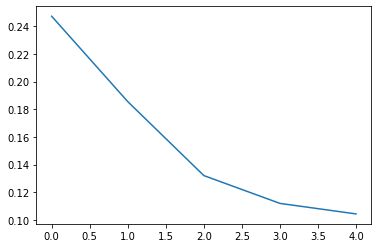

In [7]:
hist_df = pd.DataFrame(history.history)
plt.plot(hist_df['rmse'])
#plt.plot(history['val_accuracy'])
#plt.plot(history['loss'])
#plt.plot(history['val_loss'])

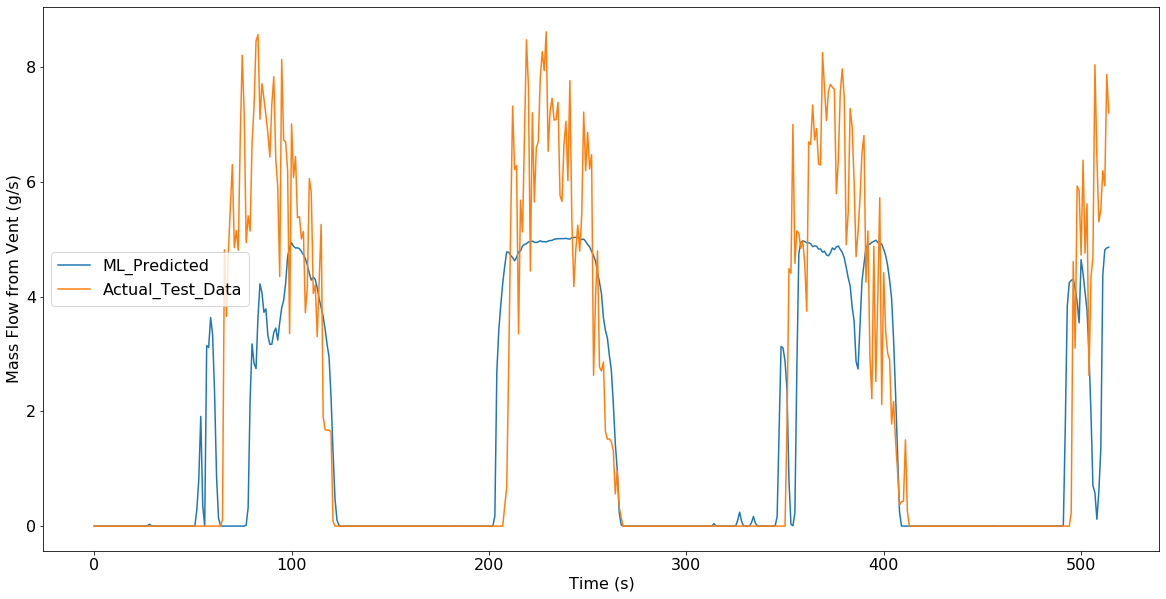

In [16]:
y_fit = model.predict(X_test) #fit to x_test

#Return to original data shape and scale
X_test_original_shape = X_test.reshape(orig_X_test_shape) #reshape from 3d time
y_test_original_shape = y_test.reshape(orig_y_test_shape)#reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = y_fit.reshape(orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']


#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))
# ax.plot(y_fit,label='ML_Fit_to_Test')
# ax.plot(y_test,label='Actual_Test_Data')

roll = 1

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.set_xlabel('Time (s)',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=16)
plt.show()

In [12]:
def create_model(learn_rate=0.01,activation='relu',dropout_rate=0.0,neurons=128):

    model = Sequential()
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))
    opt = tf.keras.optimizers.Adam(lr=learn_rate,decay=1e-5)

    model.compile(loss='mse',optimizer=opt,metrics=['mean_squared_error'])
    
    return model




In [ ]:
model = create_model(learn_rate)
history = model.fit(X_train,y_train,epochs=5,batch_size=20,validation_data=(X_test,y_test))

In [20]:
import keras.backend as K
print(K.eval(opt.lr))

0.001


In [11]:
from multiprocessing import Process

def fit_function(m,p1,p2):
    print(f'fitting your model: {m}, Learning Rate: {p1}, Optimizer {p2}')

p1 = Process(target=fit_function('LSTM 100 units', .1, 'ADAM'))
p2 = Process(target=fit_function('LSTM 50 units', .5, 'SGD'))
p1.start()
p2.start()
p1.join()
p2.join()

fitting your model: LSTM 100 units, Learning Rate: 0.1, Optimizer ADAM
fitting your model: LSTM 50 units, Learning Rate: 0.5, Optimizer SGD


In [130]:
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import pickle
import numpy as np
from sklearn import preprocessing
import os

class Dataset:
    def __init__(self,data_path,pn):
        self.pn = pn
        self.data_path = data_path
    
    def _get_date_range(self):
        if self.pn == 4:
            self.start_date = '2019-09-24'
            self.end_date = '2019-10-03'
        elif self.pn == 6:
            self.start_date = '2019-11-06'
            self.end_date = '2019-11-27'
    
    def _data_retrieve(self):
        first_go = True #flag for first time through
        self._get_date_range()
        for single_date in daterange(self.start_date,self.end_date): #"daterange()" from CO2_processing
            if os.path.exists("{}/{}.pickle".format(self.data_path,single_date)):
                print("Retrieving data for {}".format(single_date))
                if first_go: #open and create the data structure
                    with open('{}/{}.pickle'.format(self.data_path,single_date), 'rb') as handle:
                        data = pickle.load(handle)
                    first_go=False
                else: #append the next day to the dta structure
                    with open('{}/{}.pickle'.format(self.data_path,single_date), 'rb') as handle:
                        new_data = pickle.load(handle)
                    for key in data:
                        if key in new_data.keys():
                            data[key] = pd.concat([data[key],new_data[key]])
            else: 
                print("No data found for {}".format(single_date))
                print(os.listdir(self.data_path))
                continue
        return data
        
    def _preprocess(self):
        print('Removing Impulses')
        data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),self._data_retrieve()) #CO2_Processing
        print('Downsampling and Concatenating')
        data = downsample_and_concatenate(data) #CO2_Processing
        
        if self.pn == 4:
            data = sept24_26_correction(data) #CO2_Processing
            data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate #CO2_processing
            data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed.  #CO2_processing
            data['Vent_Mass'] = pd.concat([\
                                   data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-24 08:57:00')&\
                                                         (data['Vent_Mass'].index<'2019-09-26 08:00:00')],\
                                   data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-26 12:00:00')&\
                                                         (data['Vent_Mass'].index<'2019-10-03 13:00:00')].interpolate()])
        
        self.data = data
        
        

class ML_Data:
    def __init__(self,feature_columns,downsample_sec,periods_to_lag,tower,train_percent):
        self.feature_columns = feature_columns
        self.downsample_sec = downsample_sec
        self.periods_to_lag = periods_to_lag
        self.tower = tower
        self.train_percent = train_percent
    
    
    def _prepare_and_downsample(self,data):
        #get the correct data from the tower (multi or picarro)
        self.pn = data.pn
        if self.tower == 'Multi':
            tower = data['Multi']
        elif self.tower == 'Picarro':
            tower=data['Picarro']
        else:
            raise NameError('tower_id must be a valid tower, either "Multi" or "Picarro"')
        vent=data['Vent_Mass']
        tower_proc = dwn_sample(tower,self.downsample_sec) #CO2_Processing
        vent_proc = dwn_sample(vent,self.downsample_sec) #CO2_Processing
        df = pd.concat([tower_proc,vent_proc],axis=1)
        #Concatenate and add wind speed & direction if picarro data
        if self.tower == 'Picarro':
            df = wind_add(df,'ANEM_X','ANEM_Y') #CO2_functions
        #Drop columns
        if 'm_dot' not in self.feature_columns:
            self.feature_columns.append('m_dot')
        df = df[self.feature_columns]

        #Make mass flux the last column
        loc = df.columns.get_loc('m_dot')
        cols = df.columns.tolist()
        cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
        df = df[cols]   
        
        self.df_preprocessed = df
    
    def _ML_process(self,data):
        if not hasattr(self,'df_preprocessed'):
            self._prepare_and_downsample(data)
        n_periods = self.periods_to_lag#how many periods to lag
        n_features = len(self.df_preprocessed.columns)-1#how many features exist in the feature matrix (number of cols - target col)
        time_lagged = series_to_supervised(self.df_preprocessed,n_in=0,n_out=n_periods,dropnan=False) #CO2_Processing
        time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns #CO2_Processing

        #Make mass flux at t the last column
        loc = time_lagged_reframed.columns.get_loc('m_dot(t)')
        cols = time_lagged_reframed.columns.tolist()
        cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
        time_lagged_reframed = time_lagged_reframed[cols]
        self.feature_columns = cols
        
        values = time_lagged_reframed.dropna().values #Convert to numpy for processing
        min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
        values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1
        self.min_max_scalar = min_max_scalar
        
        train_size = int(len(values)*self.train_percent) 
        train = values_scaled[:train_size,:]  #Get train/test arrays
        test = values_scaled[train_size:,:]
        
        X_train,y_train = train[:,:-1], train[:,-1] #Get feature/target arrays
        X_test, y_test = test[:,:-1], test[:,-1]
        
        self.orig_X_train_shape = X_train.shape
        self.orig_X_test_shape = X_test.shape
        self.orig_y_train_shape = y_train.shape
        self.orig_y_test_shape = y_test.shape
        
        X_train = X_train.reshape((X_train.shape[0], n_periods, n_features)) 
        X_test = X_test.reshape((X_test.shape[0], n_periods, n_features))
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test   

In [117]:
import tensorflow as tf
from tensorflow import keras
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import os
from keras.models import model_from_json
import json
from keras import backend

class ML_Model_Builder:
    def __init__(self,activation,neurons,dropout_rate,learn_rate,decay):
        self.activation = activation
        self.neurons = neurons
        self.dropout_rate = dropout_rate
        self.learn_rate = learn_rate
        self.decay = decay

    def _create_model(self):
        def rmse(y_true, y_pred):
            return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
        
        model = Sequential()
        model.add(LSTM(self.neurons,activation=self.activation))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1,activation = 'sigmoid'))
        opt = tf.keras.optimizers.Adam(lr=self.learn_rate,decay=self.decay)

        model.compile(loss='mse',optimizer=opt,metrics=[rmse])
        self.model = model
        
    def _train_model(self,batch_size,epochs,data):
        self.batch_size = batch_size
        self.epochs = epochs
        if not hasattr(self,'model'):
            self._create_model()
        
        print(f"Training Model using {epochs} epochs and a batch size of {batch_size} using {data} as data")
        self.history = self.model.fit(data.X_train,data.y_train,epochs=self.epochs,batch_size=self.batch_size,validation_data=(data.X_test,data.y_test))
    
    def _fit_model(self,data):
        data.y_fit = self.model.predict(data.X_test)

In [133]:
data = Dataset('../CO2_Data_Final/',4)
data._preprocess()

Removing Impulses
Retrieving data for 2019-09-24
Retrieving data for 2019-09-25
Retrieving data for 2019-09-26
Retrieving data for 2019-09-27
Retrieving data for 2019-09-28
Retrieving data for 2019-09-29
Retrieving data for 2019-09-30
Retrieving data for 2019-10-01
Retrieving data for 2019-10-02
Retrieving data for 2019-10-03
Downsampling and Concatenating
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero


In [134]:
feature_columns = ['Pic_CO2','ANEM_X','ANEM_Y','ANEM_Z','wd','ws']
downsample_sec = 600
periods_to_lag = 5
tower = 'Picarro'
position_number = 4
train_percent = 0.6

ML_data = ML_Data(feature_columns,downsample_sec,periods_to_lag,tower,train_percent)

In [135]:
ML_data._ML_process(data)

TypeError: 'Dataset' object is not subscriptable

In [118]:
m1 = ML_Model_Builder('relu',128,0.2,1e-3,1e-5)
m1._train_model(20,5,ML_data)

Training Model using 5 epochs and a batch size of 20 using <__main__.Dataset object at 0x7f37bcae89d0> as data
Train on 775 samples, validate on 517 samples
Epoch 1/5
775/775 [==============================] - 2s 3ms/step - loss: 0.1116 - rmse: 0.2878 - val_loss: 0.1081 - val_rmse: 0.2203
Epoch 2/5
775/775 [==============================] - 1s 1ms/step - loss: 0.0780 - rmse: 0.1880 - val_loss: 0.0781 - val_rmse: 0.2466
Epoch 3/5
775/775 [==============================] - 1s 1ms/step - loss: 0.0618 - rmse: 0.1972 - val_loss: 0.0560 - val_rmse: 0.1835
Epoch 4/5
775/775 [==============================] - 1s 1ms/step - loss: 0.0455 - rmse: 0.1519 - val_loss: 0.0394 - val_rmse: 0.1309
Epoch 5/5
775/775 [==============================] - 1s 1ms/step - loss: 0.0363 - rmse: 0.1200 - val_loss: 0.0388 - val_rmse: 0.1139


In [119]:
m1._fit_model(ML_data)

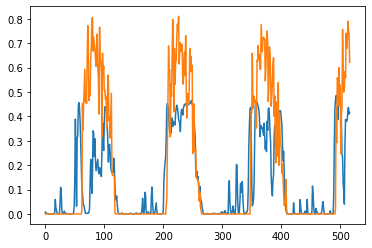

In [120]:
plt.plot(ML_data.y_fit)
plt.plot(ML_data.y_test)